In [1]:
# Import all necessary libraries.
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Reset the PN-sequence generator.
seed = 42
np.random.seed(seed)

# Estimação do deslocamento de fase com MLPRegressor 

### Define some useful functions.

In [3]:
# Utility functions.
def mod(V):
    '''QPSK modulator.'''
    ip = np.zeros((len(V),1), dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    '''Maximum likelihood demodulator (aka, optimum demodulator).'''
    c_seq = mod(np.array([0, 1, 2, 3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

### Generating the phase offsets.

Geramos um vetor com $N$ deslocamentos de fase aleatórios entre -40 e + 40 graus que serão aplicados aos símbolos QPSK.

In [4]:
# Number of QPSK symbols to be transmitted.
N = 100000

In [5]:
# Phases vary from -40 to +40 degrees.
phase_limit = np.pi/4.4

numOfAngles = 128

# Generate 128 angle values from a linearly spaced interval between -40 and 40 degrees.
angles = np.linspace(-phase_limit, phase_limit, num=numOfAngles)

# Convert the angles into complex phase values that will be applied to the transmitted QPSK symbols.
phase = np.exp(1j*angles)

In [6]:
# Generate N different random phases drawn from the set of 128 linearly spaced values.
phase_rnd = np.zeros((N,1), dtype=np.complex_)
theta_orig = np.zeros((N,1))
for i in range(0, N):
    idx = np.random.randint(len(phase))
    phase_rnd[i] = phase[idx]
    theta_orig[i] = angles[idx]

### Plot the angle variation.

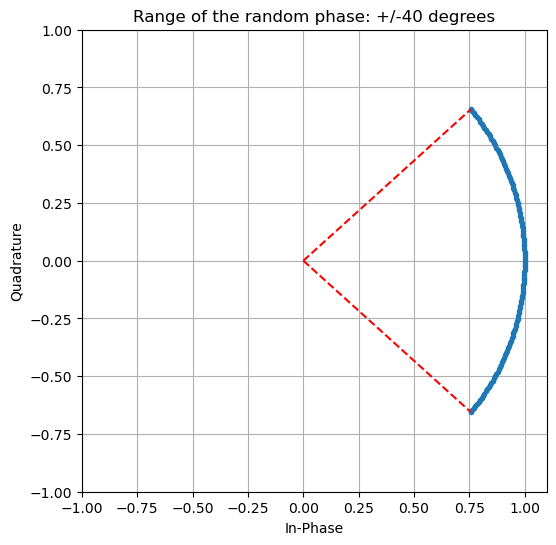

In [7]:
plt.figure(figsize=(6,6))
labelstr= '%d'% (180.0*phase_limit/np.pi)
plt.plot(phase.real, phase.imag,'.')
aux = np.exp(-1j*phase_limit)
plt.plot([0, aux.real], [0, aux.imag], '--r')
plt.plot([0, aux.real], [0, -aux.imag], '--r')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Range of the random phase: +/-' + labelstr + ' degrees')
plt.xlim(-1.0, 1.1)
plt.ylim(-1.0, 1.0)
plt.grid()
#plt.savefig('range_of_random_phase.png', dpi=600)
plt.show()

### Modulate and pass the QPSK symbols through the AWGN channel and add phase error.

Adiciona-se ruído, onde a relação Es/N0 = 27 dB.

In [8]:
# Define Es/N0 value in dB. 
# N0: densidade espectral do ruído.
EsN0dB = 27

# Tranform into linear value.
EsN0Lin = 10.0**(-(EsN0dB/10.0))

# Generate N binary symbols drawn from integer uniform distribution.
ip = np.random.randint(0,4,(N,1))
    
# Modulate binary stream into N QPSK symbols.
s = mod(ip)
    
# Generate unit variance complex-noise vector.
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
# Add phase error and pass symbols through AWGN channel.
y = s*phase_rnd + np.sqrt(EsN0Lin)*noise

# Phase of received signal.
theta = np.arctan(y.real/y.imag)

# Split arrays into training and validation subsets.
theta_train, theta_test, theta_orig_train, theta_orig_test, y_train, y_test, ip_train, ip_test, s_train, s_test = train_test_split(theta, theta_orig.ravel(), y, ip, s, test_size=0.2, random_state=1)

### Plot transmitted/received symbols and received/original phases.

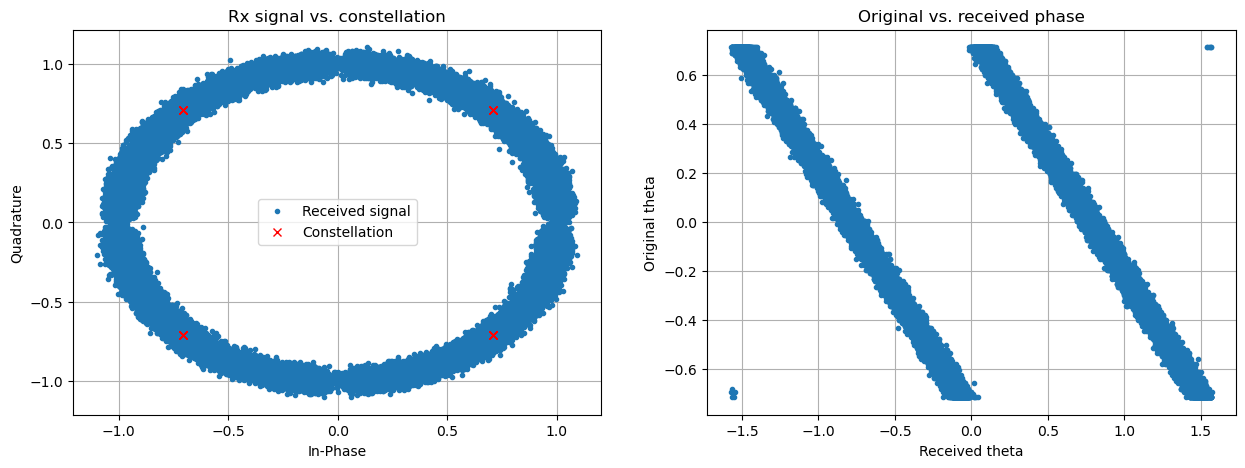

In [9]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_train.real, y_train.imag,'.', label='Received signal')
plt.plot(s_train.real, s_train.imag,'rx', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta_train, theta_orig_train,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.title('Original vs. received phase')
plt.grid()

#plt.savefig('original_signals.png', dpi=600)
plt.show()

### Train the MLP model.

A rede MLP estima a relação entre a fase do sinal recebido e a fase adicionada ao símbolo transmitido.

In [10]:
# Instantiate MLP Regressor.
#reg = MLPRegressor(hidden_layer_sizes=(400,300,50,4), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(300,200,50,4), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(200,100,50,4), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(10,5,4,2), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(100,50,30,4), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(50,25,4), random_state=1, max_iter=2000)
#reg = MLPRegressor(hidden_layer_sizes=(10,5,4,2), random_state=1, max_iter=2000)
reg = MLPRegressor(hidden_layer_sizes=(10, 5, 4), random_state=seed, max_iter=5000)

# Train MLP Regressor.
reg.fit(theta_train, theta_orig_train)

# Print number of training iterations.
print(reg.n_iter_)

23


### Predict the phase added to the transmitted QPSK symbol.

In [11]:
# Predict phase over test set.
theta_pred = reg.predict(theta_test).reshape(len(theta_test), 1)

# Undo phase-shift.
# Apply the inverse complex phase so that the phase-shit is removed.
y_rec = np.exp(-1j*theta_pred)*y_test

### Plot transmitted/received symbols after phase correction and received/original phases compared to MLP model.

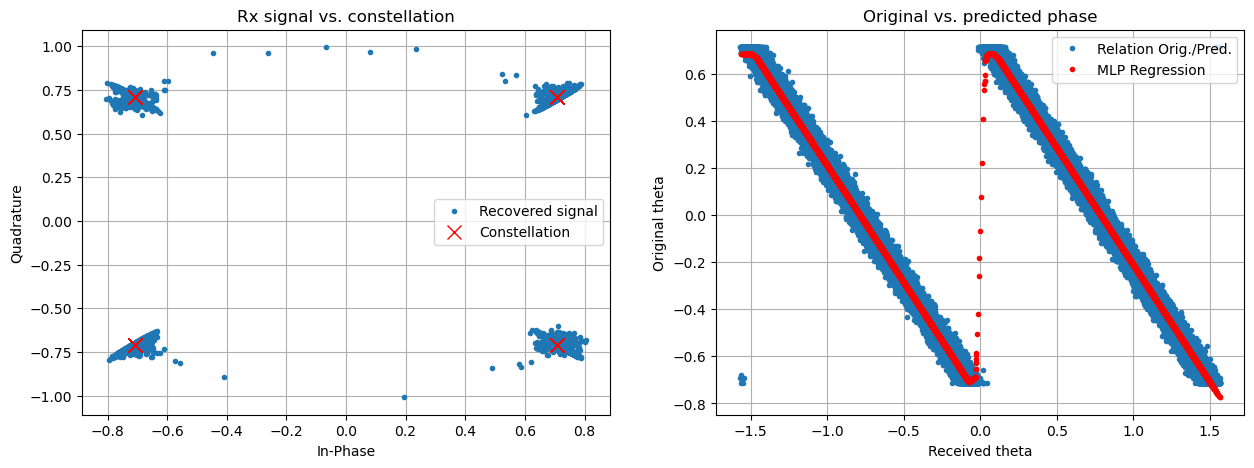

In [12]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_rec.real, y_rec.imag,'.', label='Recovered signal')
plt.plot(s_test.real, s_test.imag,'rx', markersize=10, label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta, theta_orig, '.', label='Relation Orig./Pred.')
plt.plot(theta_test, theta_pred,'.r', label='MLP Regression')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.title('Original vs. predicted phase')
plt.legend()
plt.grid()

#plt.savefig('corrected_signals.png', dpi=600)
plt.show()

### SER before and after the phase correction.

In [13]:
# Flatten the bit vector.
ip_test = ip_test.reshape(-1,)

# Simulated QPSK SER.
error = 0
for i in range(0, len(y_rec)):
    d = demod(y_rec[i])
    if((ip_test[i] != d) == True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_rec)

print('MLP SER after phase correction:', ser_simu)

# Simulated QPSK SER.
error = 0
for i in range(0, len(y_test)):
    d = demod(y_test[i])
    if((ip_test[i] != d)  ==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_test)

print('ORIG. SER before phase correction:', ser_simu)

MLP SER after phase correction: 5e-05
ORIG. SER before phase correction: 5e-05


**Observações**

+ Mesmo tendo a mesma taxa de erro de símbolo antes e após a correção de fase, a correção é necessária para evitar problemas de 
    + Perda de sincronismo: O ruído de fase pode dificultar a extração correta dos símbolos e, consequentemente, a recuperação dos dados transmitidos.
    + Interferência inter-símbolo: O ruído de fase pode causar um espalhamento dos símbolos transmitidos no tempo, o que resulta em uma sobreposição entre símbolos adjacentes, tornando difícil a recuperação correta dos símbolos transmitidos. 